In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from scipy.interpolate import LSQUnivariateSpline

import warnings
warnings.filterwarnings("ignore")

# Question 1

In [46]:
df = pd.read_csv('data/strongdrink.txt',na_values = '?')
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## a)

In [47]:
# Distribution of 'cultivar'
df['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [48]:
X = df[['alco', 'malic','tot_phen','color_int']]
y = df['cultivar']

In [49]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,random_state=20)
clf = LogisticRegression(random_state=20, solver = 'lbfgs', 
                         multi_class='multinomial',max_iter=5000).fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

table1= pd.DataFrame({"Category 1":np.append(clf.intercept_[0],clf.coef_[0]),
                      "Category 2":np.append(clf.intercept_[1],clf.coef_[1])},
                     index = ['beta_0','beta_1','beta_2','beta_3','beta_4'])
print(table1)
print('\n')
print("The error rates of category 1,2,3 are 0.13, 0, 0 respectively.")
print("The model is best at predicting category 3, which is not the one with the most prediction.")

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44

        Category 1  Category 2
beta_0  -24.027617   22.780733
beta_1    1.701734   -1.466297
beta_2   -0.265788   -0.332951
beta_3    1.224101    0.663556
beta_4    0.022507   -0.922682


The error rates of category 1,2,3 are 0.13, 0, 0 respectively.
The model is best at predicting category 3, which is not the one with the most prediction.


In [50]:
mean_sqr_err = np.mean((y_test != y_pred)**2)
print("Mean Sqaured Error: ", mean_sqr_err)

Mean Sqaured Error:  0.045454545454545456


## b)

In [64]:
Xvars = df[['alco', 'malic', 'tot_phen', 'color_int']].values
yvars = df['cultivar'].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_test_list = np.zeros(N_loo)
y_pred_list = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_pred_list[test_index] = y_pred
    y_test_list[test_index] = y_test
    MSE_vec[test_index] = (y_test != y_pred)

In [65]:
print(classification_report(y_test2, y_pred2))
print('\n')

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176





The error rates for type 1, 2, 3 are 0.16, 0.17, 0.04 respectively. Each of them is higher than that in (a). The most precise estimation in part b) is j=3.

In [30]:
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('LOOCV estimate for the test MSE:',MSE_loo,
     '\nstandard error:',MSE_loo_std)

LOOCV estimate for the test MSE: 0.07954545454545454 
standard error: 0.2705882022679695


## c)

In [71]:
k = 4
kf = KFold(k, shuffle=True, random_state=10)
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)
y_test_list_kf = np.zeros(N_loo)
y_pred_list_kf = np.zeros(N_loo)

In [72]:
k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_test_list_kf[test_index] = y_test
    y_pred_list_kf[test_index] = y_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print(classification_report(y_test_list_kf, y_pred_list_kf))
print('test estimate MSE k-fold = {}.'.format(MSE_kf))

MSE for test set 0  is 0.1590909090909091
MSE for test set 1  is 0.11363636363636363
MSE for test set 2  is 0.045454545454545456
MSE for test set 3  is 0.045454545454545456
              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176

test estimate MSE k-fold = 0.09090909090909091.


In [73]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('\nTest estimate MSE k-fold (k=4)=', MSE_kf,
      '\nTest estimate MSE standard err=', MSE_kf_std)


Test estimate MSE k-fold (k=4)= 0.09090909090909091 
Test estimate MSE standard err= 0.04821182598999188


The error rates for type 1,2,3 are 0.13,0.09,0.04 respectively. 

Compared with part a), the error rate for type 1 is the same, and the error rates for type 2 and 3 are higher in part c) than that in part a).

Compared with part b), the error rates for type 2 and 3 remain the same, and the error rate for type 1 is higher in part c) than that in part b).

# Question 2

In [74]:
df2 = pd.read_csv('data/CoolIndex.txt', header=None, names=['Age', 'CoolIndex'])
df2.head()

,Age,CoolIndex
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


## a)

<IPython.core.display.Javascript object>


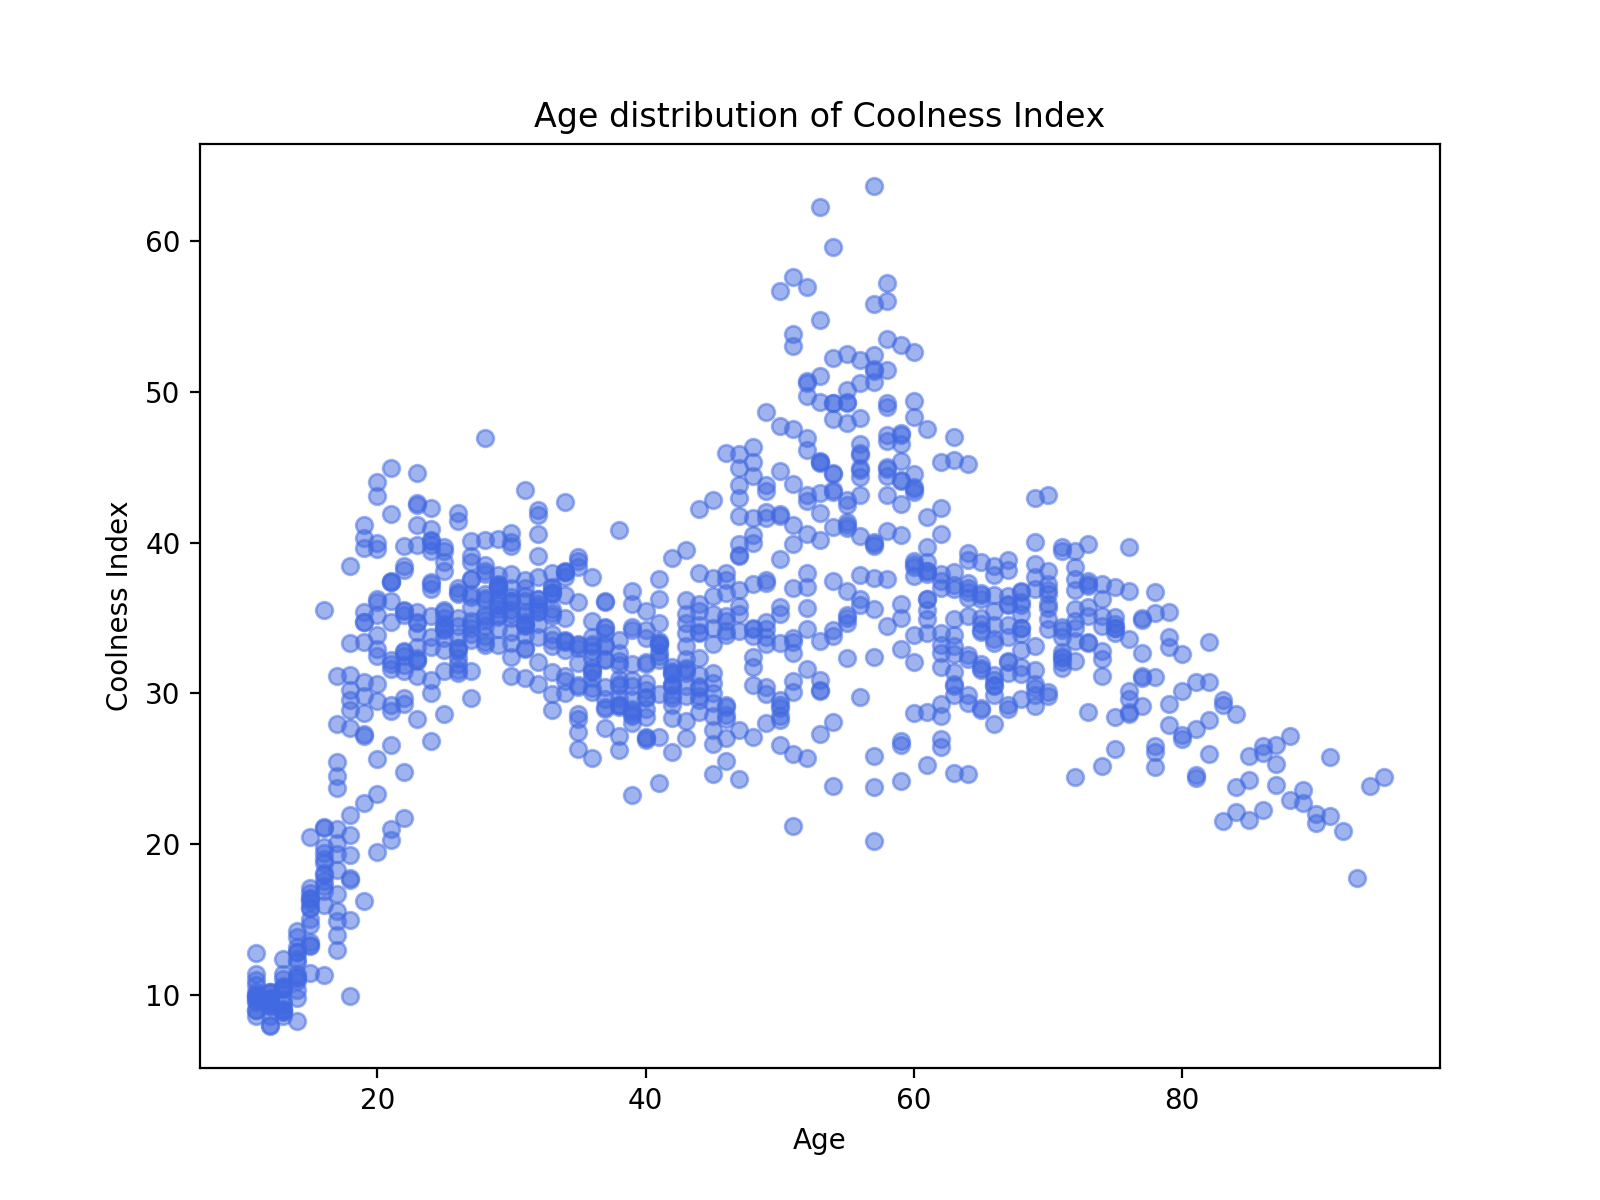

In [109]:
plt.figure(figsize=(8,6))
plt.scatter(df2.Age, df2.CoolIndex, color='royalblue', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Age distribution of Coolness Index')
plt.show()

## b)

In [85]:
df2['Age1'] = np.where((df2.Age>=11) & (df2.Age<22),1,0)
df2['Age2'] = np.where((df2.Age>=22) & (df2.Age<40),1,0)
df2['Age3'] = np.where((df2.Age>=40) & (df2.Age<59),1,0)
df2['Age4'] = np.where((df2.Age>=59) & (df2.Age<77),1,0)
df2['Age5'] = np.where((df2.Age>=77) & (df2.Age<95),1,0)


X_vals=df2[['Age1','Age2','Age3','Age4','Age5']]
result=sm.OLS(df2['CoolIndex'],X_vals).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:              CoolIndex   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              4280.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        22:11:12   Log-Likelihood:                         -3220.5
No. Observations:                 956   AIC:                                      6451.
Df Residuals:                     951   BIC:                                      6475.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [89]:
print('Estimated Step function values:\n')
print(result.params)

Estimated Step function values:

Age1    20.102457
Age2    34.475788
Age3    37.635105
Age4    35.225400
Age5    27.348167
dtype: float64


<IPython.core.display.Javascript object>


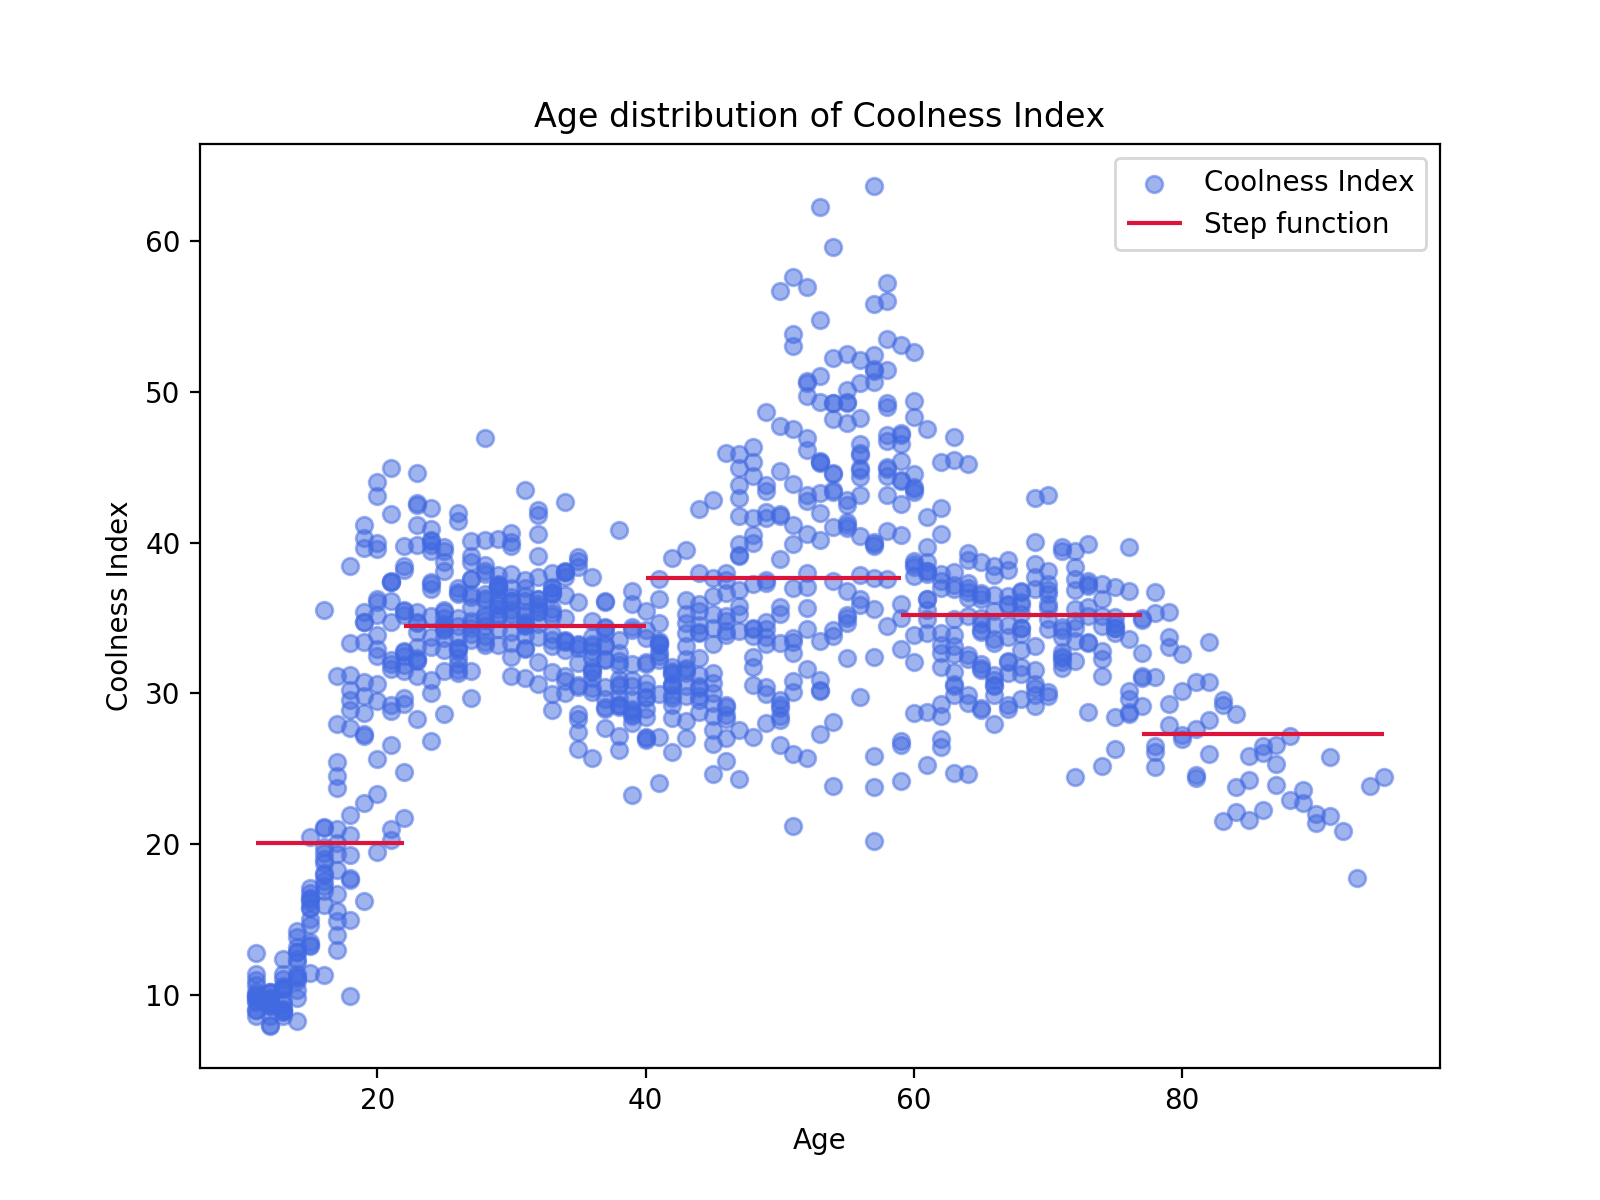

Text(0.5, 1.0, 'Age distribution of Coolness Index')

In [107]:
%matplotlib notebook
plt.figure(figsize=(8,6))
plt.scatter(df2.Age, df2.CoolIndex, color='royalblue', label='Coolness Index', alpha=0.5)
x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([22, 40, 59, 77, 95])
plt.hlines(params, x_min, x_max, color='crimson', label='Step function')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.legend(loc='upper right')
plt.title('Age distribution of Coolness Index')

In [96]:
print('The predicted coolness of a 73 year old from the stepwise function \
is {}.'.format(reg_ols.predict([0,0,0,1,0])[0]))

The predicted coolness of a 73 year old from the stepwise function is 35.22540004024275.


## c)

In [91]:
t = np.array([22,40,59,77])
df.sort_index(0, ascending=True, inplace=True)

In [92]:
grouped = df2.groupby('Age', as_index = False).mean()
spl = LSQUnivariateSpline(grouped.Age.values, grouped.CoolIndex.values, t, k=1)
age_new = np.linspace(11,95,1000)

<IPython.core.display.Javascript object>


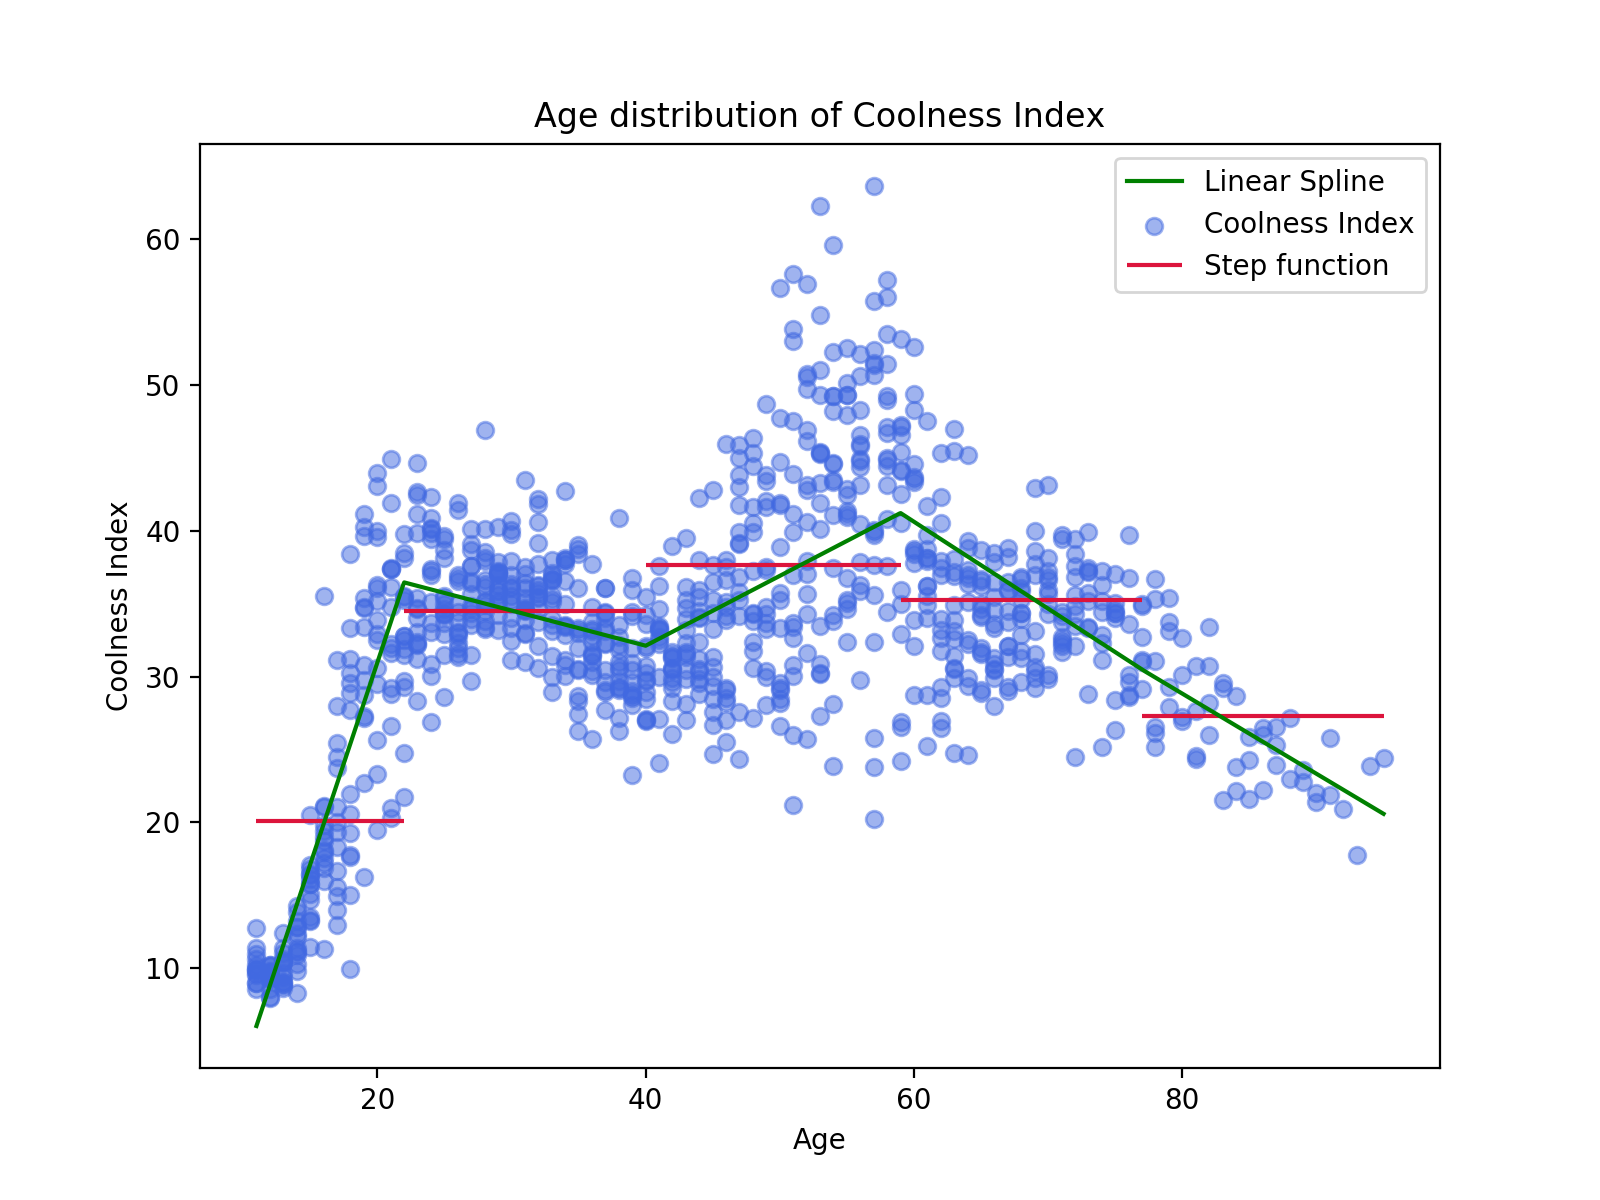

Text(0.5, 1.0, 'Age distribution of Coolness Index')

In [106]:
%matplotlib notebook
plt.figure(figsize=(8,6))
plt.scatter(df2.Age, df2.CoolIndex, color='royalblue', label='Coolness Index',alpha=0.5)
plt.hlines(params, x_min, x_max, color='crimson', label='Step function')
plt.plot(age_new, spl(age_new), color='green', label='Linear Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.legend(loc='upper right')
plt.title('Age distribution of Coolness Index')

In [95]:
print("The predicted coolness of a 73 year old is {}".format(spl(73)))

The predicted coolness of a 73 year old is 32.86784862349653


## d)

<IPython.core.display.Javascript object>


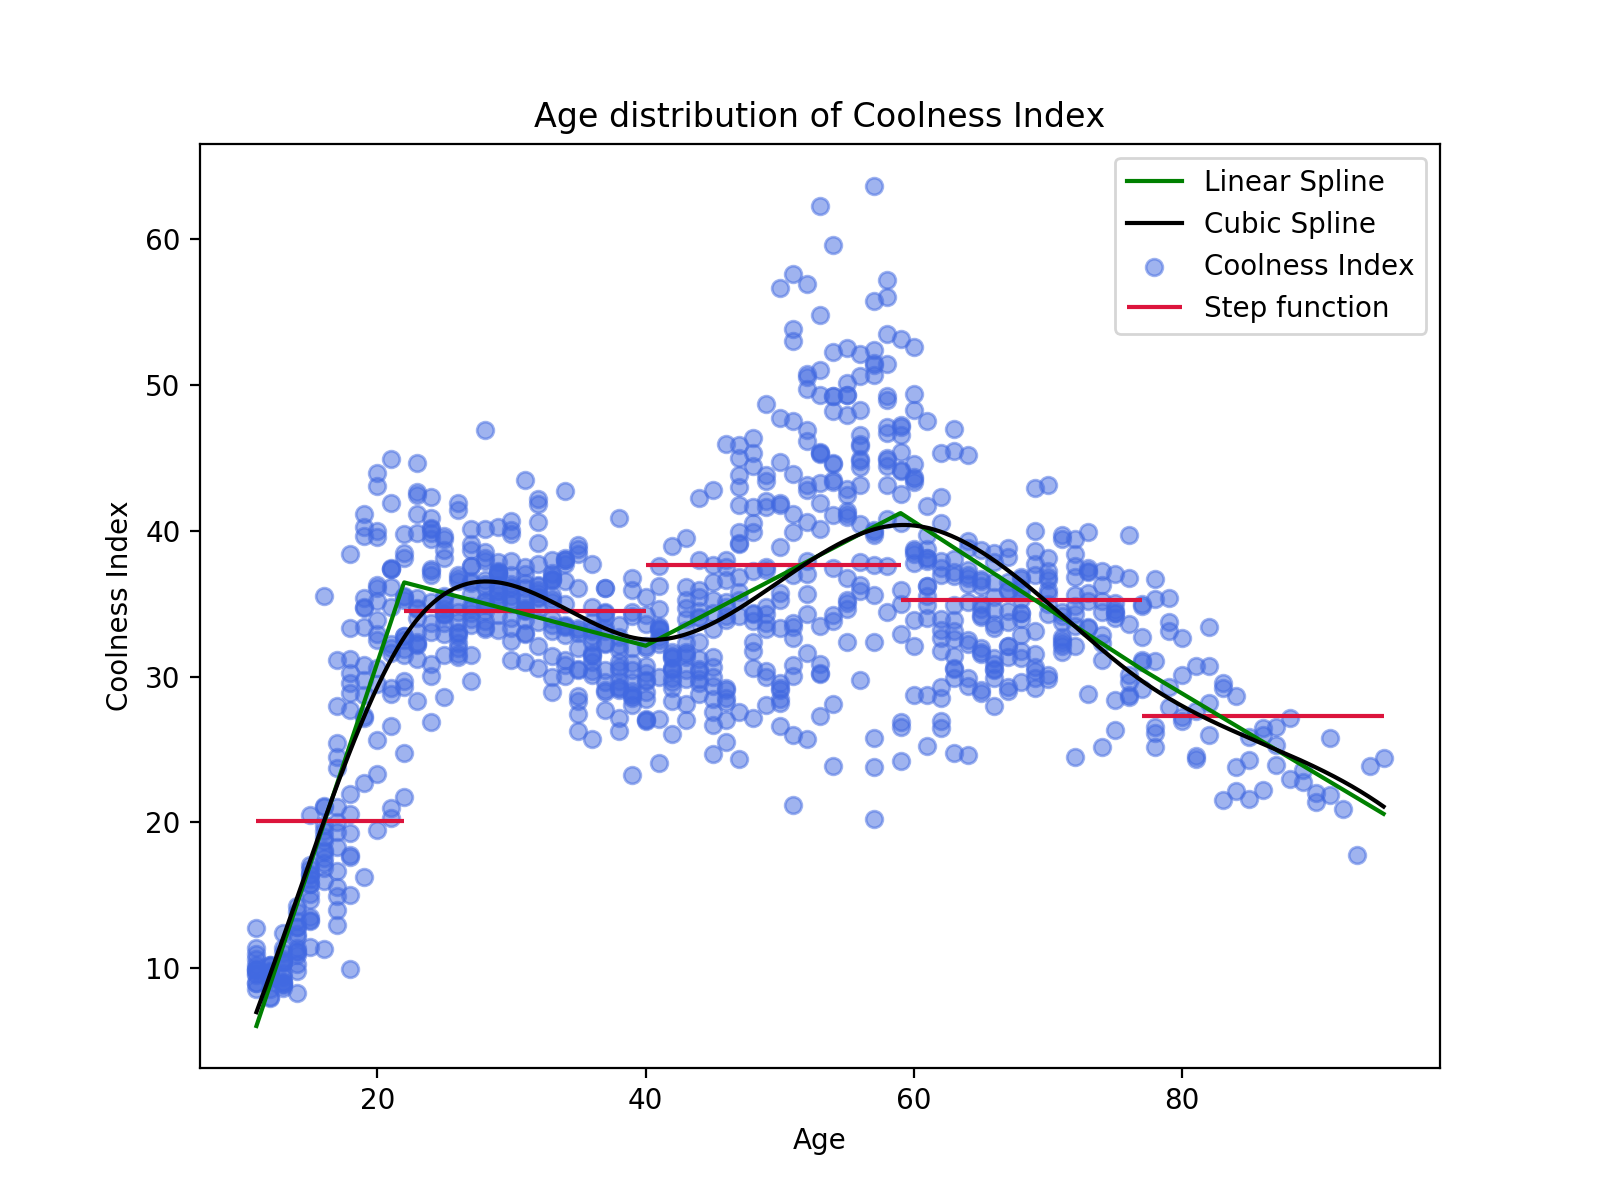

Text(0.5, 1.0, 'Age distribution of Coolness Index')

In [105]:
%matplotlib notebook
spl2 = LSQUnivariateSpline(grouped.Age.values, grouped.CoolIndex.values, t, k=3)
plt.figure(figsize=(8,6))
plt.scatter(df2.Age, df2.CoolIndex, color='royalblue', label='Coolness Index', alpha=0.5)
plt.hlines(params, x_min, x_max, color='crimson', label='Step function')
plt.plot(age_new, spl(age_new), color='green', label='Linear Spline')
plt.plot(age_new, spl2(age_new), 'k-', label='Cubic Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.legend(loc='upper right')
plt.title('Age distribution of Coolness Index')

In [102]:
print("The predicted coolness of a 73 year old is {}".format(spl2(73)))

The predicted coolness of a 73 year old is 32.642301066279764
